In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Momentum trading

[*********************100%***********************]  7 of 7 completed


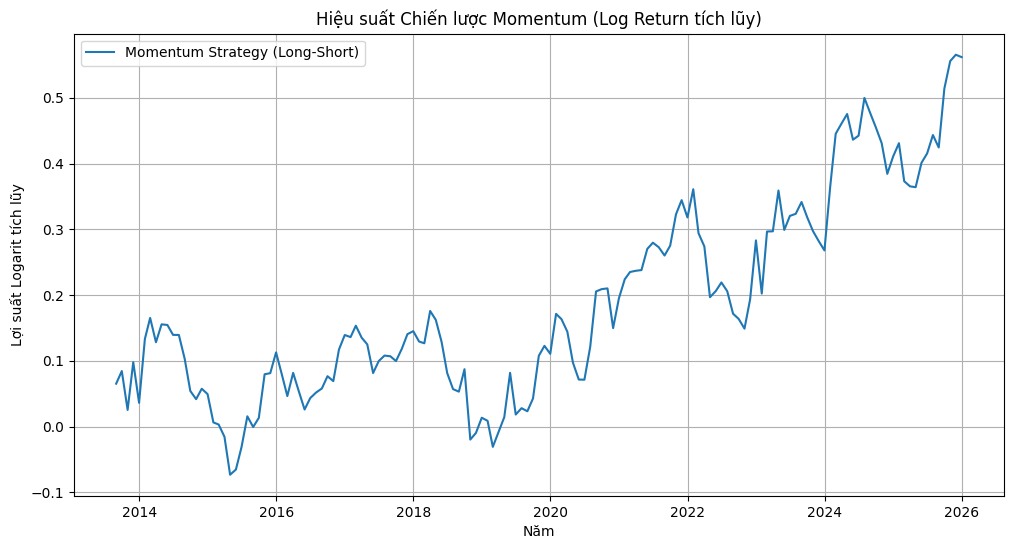


--- KẾT QUẢ ---
Tổng số tháng giao dịch: 149
Tổng lợi suất tích lũy: 0.5620
Trung bình lợi suất tháng: 0.0038


In [2]:
# Slide 41 CF_week2and3

def get_data(tickers, start_date):
    # Thêm auto_adjust=False để lấy lại cột Adj Close
    data = yf.download(tickers, start=start_date, auto_adjust=False)['Adj Close']
    return data

def calculate_momentum_strategy(data, n_stocks=5):

    # 1. Resample daily prices into month-end prices (Lấy giá cuối tháng)
    monthly_prices = data.resample('ME').last()

    # 2. Calculate monthly log returns (Tính lợi suất logarit)
    # Công thức: ln(P_t / P_{t-1})
    monthly_log_returns = np.log(monthly_prices / monthly_prices.shift(1))

    # Tạo DataFrame để lưu lợi nhuận danh mục
    portfolio_returns = []
    index_dates = []

    # Bắt đầu vòng lặp từ tháng thứ 2 (để có dữ liệu return của tháng trước đó để rank)
    # Chúng ta dùng return tháng T để xếp hạng, và giữ vị thế trong tháng T+1

    for i in range(1, len(monthly_log_returns) - 1):
        # Lấy return của tháng hiện tại để xếp hạng (Formation Period)
        current_month_rets = monthly_log_returns.iloc[i]

        # Loại bỏ các mã không có dữ liệu (NaN)
        current_month_rets = current_month_rets.dropna()

        if len(current_month_rets) < 2 * n_stocks:
            continue # Không đủ cổ phiếu để chọn

        # 3. Rank stocks by returns (Xếp hạng)
        ranked_stocks = current_month_rets.sort_values(ascending=False)

        # 4. Long top n, Short bottom n
        long_stocks = ranked_stocks.head(n_stocks).index
        short_stocks = ranked_stocks.tail(n_stocks).index

        # 5. Calculate Return for the NEXT month (Holding Period)
        # Lợi nhuận thực tế là lợi nhuận của tháng sau (i+1) dựa trên danh mục chọn ở tháng i
        next_month_rets = monthly_log_returns.iloc[i+1]

        # Lấy lợi suất trung bình (Equal weighting)
        long_ret = next_month_rets[long_stocks].mean()
        short_ret = next_month_rets[short_stocks].mean()

        # 6. Portfolio Return
        # Long thắng khi giá tăng, Short thắng khi giá giảm (Short return = -Asset Return)
        # Công thức slide: (Long + Short) / 2.
        # Lưu ý: Trong thực tế short return là (Giá bán - Giá mua)/Giá bán.
        # Với log return, Short PnL = -1 * Log Return của tài sản đó.

        total_return = (long_ret - short_ret) / 2

        portfolio_returns.append(total_return)
        index_dates.append(monthly_log_returns.index[i+1])

    # Tổng hợp kết quả
    strategy_df = pd.DataFrame({'Monthly_Return': portfolio_returns}, index=index_dates)
    strategy_df['Cumulative_Return'] = strategy_df['Monthly_Return'].cumsum()

    return strategy_df

# --- CHẠY THỬ ---


universe = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA', # Tech
]

# Thời gian: Mid-2013 onward
start_date = '2013-06-01'

# Chạy quy trình
df_prices = get_data(universe, start_date)
strategy_result = calculate_momentum_strategy(df_prices, n_stocks=3)

# --- VẼ BIỂU ĐỒ ---
plt.figure(figsize=(12, 6))
plt.plot(strategy_result.index, strategy_result['Cumulative_Return'], label='Momentum Strategy (Long-Short)')
plt.title('Hiệu suất Chiến lược Momentum (Log Return tích lũy)')
plt.xlabel('Năm')
plt.ylabel('Lợi suất Logarit tích lũy')
plt.legend()
plt.grid(True)
plt.show()

# In thống kê cơ bản
print("\n--- KẾT QUẢ ---")
print(f"Tổng số tháng giao dịch: {len(strategy_result)}")
print(f"Tổng lợi suất tích lũy: {strategy_result['Cumulative_Return'].iloc[-1]:.4f}")
print(f"Trung bình lợi suất tháng: {strategy_result['Monthly_Return'].mean():.4f}")

- Alpha so với Benchmark: Chiến lược này có thắng được thị trường chung (như SPY) không?

- Sharpe Ratio: Lợi nhuận có xứng đáng với rủi ro bỏ ra không?

- P-value (T-statistic): "Liệu kết quả này có phải là ngẫu nhiên không?".

In [3]:
import scipy.stats as stats


def analyze_strategy_statistics(strategy_df, benchmark_ticker='SPY'):
    """
    Thực hiện kiểm định thống kê và so sánh với Benchmark
    """
    print(f"\n--- PHÂN TÍCH THỐNG KÊ CHIẾN LƯỢC VS {benchmark_ticker} ---")

    # 1. Tải dữ liệu Benchmark (SPY)
    if strategy_df is None or strategy_df.empty:
        print("Lỗi: Không có dữ liệu chiến lược để phân tích.")
        return

    start = strategy_df.index[0]
    end = strategy_df.index[-1]

    print(f"Đang tải dữ liệu {benchmark_ticker} để so sánh...")
    benchmark = yf.download(benchmark_ticker, start=start, end=end, progress=False)['Close']
    bench_monthly = benchmark.resample('ME').last()

    bench_returns = np.log(bench_monthly / bench_monthly.shift(1)).dropna()

    # Cắt dữ liệu cho khớp ngày tháng (Alignment)
    common_dates = strategy_df.index.intersection(bench_returns.index)
    strat_rets = strategy_df.loc[common_dates, 'Monthly_Return']
    bench_rets = bench_returns.loc[common_dates]

    if len(strat_rets) < 2:
        print("Không đủ dữ liệu chung để so sánh thống kê.")
        return

    # 2. Tính toán các chỉ số cơ bản (Ép kiểu về float để tránh lỗi Series)
    # Annualized Return
    mean_ret_strat = float(strat_rets.mean() * 12)
    mean_ret_bench = float(bench_rets.mean() * 12)

    # Volatility
    vol_strat = float(strat_rets.std() * np.sqrt(12))
    vol_bench = float(bench_rets.std() * np.sqrt(12))

    # Sharpe Ratio
    sharpe_strat = mean_ret_strat / vol_strat if vol_strat != 0 else 0
    sharpe_bench = mean_ret_bench / vol_bench if vol_bench != 0 else 0

    # 3. Hypothesis Testing
    t_stat_result = stats.ttest_1samp(strat_rets, 0)

    # Xử lý kết quả T-test (đôi khi nó trả về mảng, cần lấy giá trị đầu tiên)
    try:
        t_stat = float(t_stat_result.statistic)
        p_value = float(t_stat_result.pvalue)
    except AttributeError:
        # Cho các phiên bản scipy cũ hơn
        t_stat = float(t_stat_result[0])
        p_value = float(t_stat_result[1])

    # 4. In Báo Cáo
    print(f"Khoảng thời gian: {start.date()} đến {end.date()} ({len(strat_rets)} tháng)")

    print("\n1. HIỆU SUẤT (Annualized):")
    print(f"   - Chiến lược (Momentum): {mean_ret_strat:.2%}")
    print(f"   - Benchmark ({benchmark_ticker}):     {mean_ret_bench:.2%}")
    diff = mean_ret_strat - mean_ret_bench
    print(f"   => Chênh lệch (Alpha):   {diff:.2%}")

    print("\n2. RỦI RO (Volatility & Sharpe):")
    print(f"   - Sharpe Chiến lược: {sharpe_strat:.2f}")
    print(f"   - Sharpe Benchmark:  {sharpe_bench:.2f}")

    print("\n3. KIỂM ĐỊNH NGẪU NHIÊN (QUAN TRỌNG NHẤT):")
    print(f"   - T-statistic: {t_stat:.4f}")
    print(f"   - P-value:     {p_value:.4f}")

    print("-" * 40)
    if p_value < 0.05:
        print("KẾT LUẬN: Lợi nhuận có ý nghĩa thống kê (P-value < 0.05).")
        print("   -> Khả năng kết quả này sử dụng được.")
        print("   -> Chiến lược có hiệu quả thực sự.")
    else:
        print("KẾT LUẬN: Lợi nhuận KHÔNG có ý nghĩa thống kê (P-value >= 0.05).")
        print("   -> Không thể loại trừ khả năng đây chỉ là sự trùng hợp ngẫu nhiên.")
        print("   -> Cần xem xét lại chiến lược.")


analyze_strategy_statistics(strategy_result)


--- PHÂN TÍCH THỐNG KÊ CHIẾN LƯỢC VS SPY ---
Đang tải dữ liệu SPY để so sánh...


C:\Users\Tam Nguyen\AppData\Local\Temp\ipykernel_8624\2699535723.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  benchmark = yf.download(benchmark_ticker, start=start, end=end, progress=False)['Close']


Khoảng thời gian: 2013-08-31 đến 2025-12-31 (147 tháng)

1. HIỆU SUẤT (Annualized):
   - Chiến lược (Momentum): 3.90%
   - Benchmark (SPY):     13.19%
   => Chênh lệch (Alpha):   -9.29%

2. RỦI RO (Volatility & Sharpe):
   - Sharpe Chiến lược: 0.30
   - Sharpe Benchmark:  0.92

3. KIỂM ĐỊNH NGẪU NHIÊN (QUAN TRỌNG NHẤT):
   - T-statistic: 1.0340
   - P-value:     0.3029
----------------------------------------
KẾT LUẬN: Lợi nhuận KHÔNG có ý nghĩa thống kê (P-value >= 0.05).
   -> Không thể loại trừ khả năng đây chỉ là sự trùng hợp ngẫu nhiên.
   -> Cần xem xét lại chiến lược.


C:\Users\Tam Nguyen\AppData\Local\Temp\ipykernel_8624\2699535723.py:36: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mean_ret_bench = float(bench_rets.mean() * 12)
C:\Users\Tam Nguyen\AppData\Local\Temp\ipykernel_8624\2699535723.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vol_bench = float(bench_rets.std() * np.sqrt(12))


In [4]:
! git add .
! git commit -m "Update Momentum"
! git push

[main b0d128b] Update Momentum
 7 files changed, 87094 insertions(+)
 create mode 100644 LAB_2_3/MOMENTUM.ipynb
 create mode 100644 LAB_2_3/SMA.ipynb
 create mode 100644 LAB_4/OUTLIERS.ipynb
 create mode 100644 LAB_5/Bollinger Bands.ipynb
 create mode 100644 LAB_5/Time_Series.ipynb
 create mode 100644 LAB_6/Lab6_Pairs_Trading.ipynb
 create mode 100644 LAB_GIUAKI/Bollinger Bands.ipynb


To https://github.com/tamnguyen-2905/CF_Trang22110234_Thanh22110203_Tam22110193.git
   e2b7202..b0d128b  main -> main
